In [ ]:
!pip install torchvision==0.14
!pip install matplotlib
!pip install "squirrel-core[torch]"
!pip install "squirrel-datasets-core[torchvision]"

!pip install transformers

In [1]:
import torch
import torch.utils.data as tud
from torch.utils.data._utils.collate import default_collate as torch_default_collate

import torchvision.transforms as tr

import matplotlib.pyplot as plt

from squirrel.driver import MessagepackDriver
from squirrel_datasets_core.driver import TorchvisionDriver

def get_dataloader_eval(batch_size: int) -> tud.DataLoader:
    """Dataloader to load evaluation/test dataset."""

    url = "/content/drive/My Drive/mmchallenge/squirrel_middlebury_patched"  # path to unzipped data folder containing *.gz files
    # Get iterator from driver
    driver = MessagepackDriver(url)
    it = driver.get_iter()

    #############################
    ## YOUR PREPROCESSING HERE ##
    preprocess = tr.Compose([
        lambda x: x
    ])
    #############################

    dataset = (
        it
        .map(preprocess)
        .batched(batch_size, torch_default_collate, drop_last_if_not_full=False)
        .to_torch_iterable()
    )
    return tud.DataLoader(dataset, shuffle=None, batch_size=None)
  
def get_dataloader_train(batch_size: int, shuffe_size: int = 100, num_workers: int = 0) -> tud.DataLoader:
    """Dataloader to Sintel training data."""
    # Path to folder containing the `Sintel` folder previously donwloaded.
    url = "./"

    driver = TorchvisionDriver("SintelStereo", url=url)
    it = driver.get_iter()

    dataset = (
        it
        .shuffle(shuffe_size)
        .split_by_worker_pytorch()
        #############################################################
        ### YOUR PREPROCESSING, COLLATING, AUGMENTATION, ETC. HERE ##
        #############################################################
        .batched(batch_size, torch_default_collate, drop_last_if_not_full=True)
        .to_torch_iterable()
    )
    return tud.DataLoader(dataset, shuffle=None, batch_size=None, num_workers=num_workers)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
batch_size = 4
dl_eval = get_dataloader_eval(batch_size)
it = iter(dl_eval)

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

In [ ]:
model.cuda()

In [ ]:
left_embeddings = torch.zeros(306, 768)
right_embeddings = torch.zeros(306, 768)

# Calculate all embeddings
for i, d in enumerate(dl_eval):
    print(i)
    bs = d["img_l"].shape[0]
    img_l = torch.unbind(d["img_l"]) # 32, 3, 360, 360
    inputs_l = feature_extractor(images=img_l, return_tensors="pt")
    inputs_l = inputs_l["pixel_values"].cuda()
    outputs_l = model(inputs_l)
    
    img_r = torch.unbind(d["img_r"])  # 32, 3, 360, 360
    inputs_r = feature_extractor(images=img_r, return_tensors="pt")
    inputs_r = inputs_r["pixel_values"].cuda()
    outputs_r = model(inputs_r)


    left_embeddings[i * batch_size:i * batch_size + bs, :] = outputs_l.pooler_output.data.cpu()
    right_embeddings[i * batch_size:i * batch_size + bs, :] = outputs_r.pooler_output.data.cpu()

tensor(0.5458)


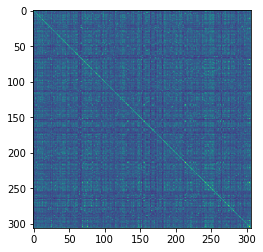

In [22]:
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-6)

match_matrix = torch.zeros(306, 306)
accuracy = []
for i in range(306):
    for j in range(306):
        match_matrix[i][j] = cos(left_embeddings[i:i+1], right_embeddings[j:j+1])
    match = torch.argmax(match_matrix[i:i+1], dim=1)
    if match == i:
        accuracy.append(1.)
    else:
        accuracy.append(0.)

print(torch.tensor(accuracy).mean())
plt.imshow(match_matrix)

In [20]:
torch.argmax(match_matrix[i:i+1], dim=1).shape

torch.Size([1])